<a href="https://colab.research.google.com/github/emmanuelsheshi/unetTest/blob/main/RescueNetTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!gdown "https://drive.google.com/file/d/1--bWWNysifDVFES9gbZrPg_P2jqiBL4e/view?usp=drive_link" --fuzzy


Downloading...
From (original): https://drive.google.com/uc?id=1--bWWNysifDVFES9gbZrPg_P2jqiBL4e
From (redirected): https://drive.google.com/uc?id=1--bWWNysifDVFES9gbZrPg_P2jqiBL4e&confirm=t&uuid=c1fa16a3-c07c-4782-92d1-30ca0710e4de
To: /content/RescueNet.zip
100% 23.7G/23.7G [04:24<00:00, 89.7MB/s]


In [ ]:
!unzip RescueNet.zip -d RescueNet

Streaming output truncated to the last 5000 lines.
 extracting: RescueNet/train/train-org-img/20435.jpg  
 extracting: RescueNet/train/train-org-img/14215.jpg  
 extracting: RescueNet/train/train-org-img/14009.jpg  
 extracting: RescueNet/train/train-org-img/14259.jpg  
 extracting: RescueNet/train/train-org-img/14198.jpg  
 extracting: RescueNet/train/train-org-img/14072.jpg  
 extracting: RescueNet/train/train-org-img/11820.jpg  
 extracting: RescueNet/train/train-org-img/14118.jpg  
 extracting: RescueNet/train/train-org-img/14229.jpg  
 extracting: RescueNet/train/train-org-img/14004.jpg  
 extracting: RescueNet/train/train-org-img/11263.jpg  
 extracting: RescueNet/train/train-org-img/14272.jpg  
 extracting: RescueNet/train/train-org-img/14102.jpg  
 extracting: RescueNet/train/train-org-img/13267.jpg  
 extracting: RescueNet/train/train-org-img/14255.jpg  
 extracting: RescueNet/train/train-org-img/14268.jpg  
 extracting: RescueNet/train/train-org-img/13561.jpg  
 extracting: R

In [ ]:
!pip install tensorflow-addons
!pip install segmentation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.0/133.0 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for segmentation: filename=segmentation-0.2.2-cp310-cp310-linux_x86_64.whl size=553411 sha256=0b9fb10c4407072eb9a9d7c6f46235cb08f49cf78f3ba8c819ba2e160ad502a1
  Stored in directory: /root/.cache/pip/wheels/4b/9b/a8/82ea6c45ff40c9288c4f57ac0c2c54b950312afeb7fdc72b5a
Successfully built segmentation


In [ ]:


import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D,\
                             Dropout, Layer, Input, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import Sequence
import tensorflow.image as tfimg


import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import math
import random
import glob
import tqdm
import time
from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)
import pickle


In [ ]:
#process the images

#resize the images
SIZE_X = 256
SIZE_Y = 256
n_classes=11 #Number of classes for segmentation

train_images = []

In [ ]:

#for now i want to limit this to the first 100 images
train_images = []
directory_path ="RescueNet/train/train-org-img"

image_paths = glob.glob(os.path.join(directory_path, "*.jpg"))

image_paths.sort(key=lambda x: int(os.path.basename(x).split('.')[0]))

image_limit = 199
for count,img_path in enumerate(tqdm.tqdm(image_paths)):
      # print(img_path)
      if count <= image_limit:
        img = cv2.imread(img_path,0)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = img*(1./255)

        train_images.append(img)
# print(train_images)

100%|██████████| 3595/3595 [00:27<00:00, 131.62it/s]


In [ ]:
# convet images to numpy array
train_images = np.array(train_images)
train_images.shape

(200, 256, 256)

In [ ]:
import os
import glob
import cv2
from tqdm import tqdm
import re

# Directory containing the mask files
directory_path_masks = "RescueNet/train/train-label-img"

# Step 1: Get all mask files in the directory that contain "_lab" in their names
image_mask_paths = glob.glob(os.path.join(directory_path_masks, "*_lab.*"))

# Limit to the first 200 files for renaming
rename_limit = 200

# Rename only the first 200 mask files
for count, mask_file in enumerate(image_mask_paths):
    # if count >= rename_limit:
    #     break  # Stop if the count exceeds the rename limit

    # Extract the directory and filename
    dir_name = os.path.dirname(mask_file)
    base_name = os.path.basename(mask_file)

    # Remove "_lab" from the filename
    new_base_name = base_name.replace("_lab", "")

    # Construct the new file path
    new_mask_file = os.path.join(dir_name, new_base_name)

    # Rename the file
    os.rename(mask_file, new_mask_file)

    # Confirm that the old file does not exist and new file exists
    if not os.path.exists(mask_file) and os.path.exists(new_mask_file):
        print(f"Renamed: {mask_file} -> {new_mask_file}")
    else:
        print(f"Error renaming: {mask_file}")




In [ ]:
# directory_path_masks = "RescueNet/train/train-label-img"
# # Step 2: Update the list of image paths after renaming
# image_mask_paths = glob.glob(os.path.join(directory_path_masks, "*.png"))

# # Filter out any files that might still contain "_lab"
# image_mask_paths = [path for path in image_mask_paths if "_lab" not in os.path.basename(path)]

# # Improved sorting function
# def extract_number(filename):
#     # This will find all sequences of digits in the filename
#     matches = re.findall(r'\d+', filename)
#     # Convert them to integers and return the first one, or float('inf') if not found
#     return int(matches[-1]) if matches else float('inf')

# image_mask_paths.sort(key=lambda x: extract_number(os.path.basename(x)))

# # List to store processed masks
# train_masks = []

# # Limit the number of images to be processed
# image_limit = 200  # Assuming you want to process 200 images

# # Step 3: Process the renamed images
# for count, img_path in enumerate(tqdm(image_mask_paths)):
#     if count >= image_limit:
#         break  # Stop if the count exceeds the image limit

#     # Read the image in grayscale
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)

#     # Append the processed image to the list
#     train_masks.append(img)

#     # Print the path of the processed file
#     print(f"Processed file {count + 1}: {img_path}")

# # `train_masks` now contains the processed images

In [ ]:
directory_path_masks ="RescueNet/train/train-label-img"
train_masks = []

image_paths_mask = glob.glob(os.path.join(directory_path_masks, "*.png"))

image_paths_mask.sort(key=lambda x: int(os.path.basename(x).split('.')[0]))

image_limit = 199
for count,img_path in enumerate(tqdm(image_paths_mask)):
      # print(img_path)
      if count <= image_limit:
        img = cv2.imread(img_path,0)
        img = cv2.resize(img, (SIZE_Y, SIZE_X),interpolation=cv2.INTER_NEAREST)


        train_masks.append(img)

100%|██████████| 3595/3595 [00:17<00:00, 205.02it/s]


In [ ]:
# convert the masks to a numy array
train_masks = np.array(train_masks)
train_masks.shape

(200, 256, 256)

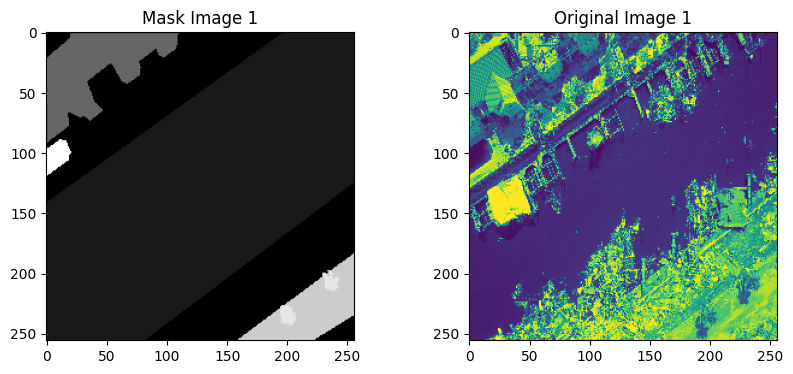

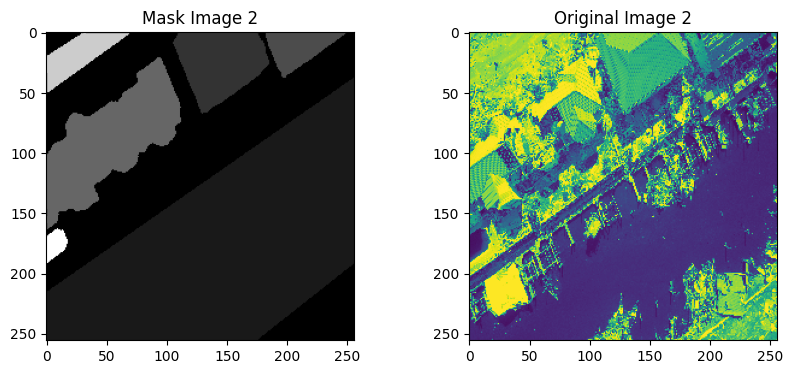

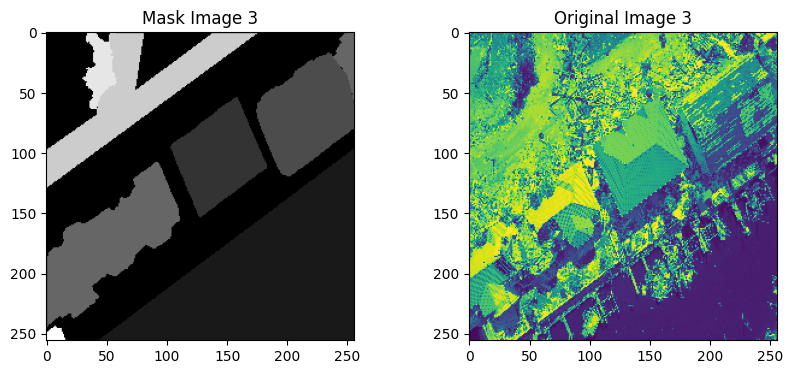

In [ ]:
import matplotlib.pyplot as plt

# Number of images to display
num_images = 3

# Loop through the first 5 images
for i in range(num_images):
    # Plot the mask image
    plt.figure(figsize=(10, 4))

    # Plot the mask image
    plt.subplot(1, 2, 1)
    plt.imshow(train_masks[i], cmap='gray')
    plt.title(f"Mask Image {i+1}")

    # Plot the original image
    plt.subplot(1, 2, 2)
    plt.imshow(train_images[i])
    plt.title(f"Original Image {i+1}")


    plt.show()





In [ ]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
from keras.utils import normalize

In [ ]:
#here you padded with 1
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

train_images.shape, train_masks_input.shape



((200, 256, 256, 1), (200, 256, 256, 1))

In [ ]:
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.1, random_state = 0)


In [ ]:
#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

In [ ]:
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

Class values in the dataset are ...  [ 0  1  2  3  4  5  6  7  8  9 10]


In [ ]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [ ]:

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:


from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_masks_reshaped_encoded),
                                                  y=train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

Class weights are...: [ 0.13778733  0.9286694   5.44105407  3.86662914  7.63739616  1.2888011
 32.61966209  1.67281375  1.89913318  6.79077459 70.90952371]


In [ ]:
IMG_HEIGHT =   X_train.shape[1]
IMG_WIDTH  =   X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS

(256, 256, 1)

In [ ]:
#definition of model

from tensorflow.keras.layers import concatenate

def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [ ]:
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

model.save('best_model.keras')



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

# Define callbacks
model_checkpoint = ModelCheckpoint(
    'best_model.keras',  # Path where to save the model file
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # Mode to determine the best model ('min' for minimizing loss)
    verbose=1  # Verbosity mode
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    mode='min',  # Mode to determine early stopping ('min' for minimizing loss)
    verbose=1  # Verbosity mode
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.2,  # Factor by which the learning rate will be reduced
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    mode='min',  # Mode to determine when to reduce learning rate ('min' for minimizing loss)
    verbose=1  # Verbosity mode
)

csv_logger = CSVLogger(
    'training_log.csv',  # Path where to save the log file
    append=True,  # Whether to append to an existing file
    separator=','  # Delimiter to use in the CSV file
)

# tensorboard = TensorBoard(
#     log_dir='./logs',  # Directory where to save the TensorBoard logs
#     histogram_freq=1,  # Frequency (in epochs) at which to compute activation and weight histograms
#     write_graph=True,  # Whether to visualize the graph
#     write_images=True  # Whether to visualize model weights
# )

# Train the model with callbacks
history = model.fit(
    X_train,
    y_train_cat,
    batch_size=16,
    verbose=1,
    epochs=50,
    validation_data=(X_test, y_test_cat),
    callbacks=[model_checkpoint, early_stopping, reduce_lr, csv_logger],
    shuffle=False
)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.3270 - loss: 2.2153 
Epoch 1: val_loss improved from inf to 1.93841, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 141s 14s/step - accuracy: 0.3418 - loss: 2.2013 - val_accuracy: 0.7033 - val_loss: 1.9384 - learning_rate: 0.0010
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6819 - loss: 1.6641 
Epoch 2: val_loss improved from 1.93841 to 1.49934, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 129s 14s/step - accuracy: 0.6801 - loss: 1.6607 - val_accuracy: 0.7035 - val_loss: 1.4993 - learning_rate: 0.0010
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6844 - loss: 1.4197 
Epoch 3: val_loss improved from 1.49934 to 1.42468, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 145s 15s/step - accuracy: 0.6825 - loss: 1.4230 - val_accuracy: 0.7035 - val_loss: 1.4247 - learning_rate: 0.0010
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6844 - loss: 1.3398 


In [ ]:

# import gc
# # del variable_name  # Delete unnecessary variables
# gc.collect()  # Trigger garbage collection
X_train.shape , X_test.shape




((144, 256, 256, 1), (20, 256, 256, 1))

In [ ]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 16,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test_cat),
                    class_weight=class_weights,
                    shuffle=False)

model.save('test.hdf5')

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 147s 15s/step - accuracy: 0.2412 - loss: 2.3053 - val_accuracy: 0.6982 - val_loss: 1.8146
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 156s 17s/step - accuracy: 0.6662 - loss: 1.7815 - val_accuracy: 0.7020 - val_loss: 1.6692
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 189s 15s/step - accuracy: 0.6803 - loss: 1.5269 - val_accuracy: 0.7035 - val_loss: 1.3622
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 138s 15s/step - accuracy: 0.6825 - loss: 1.3580 - val_accuracy: 0.7035 - val_loss: 1.3427
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 145s 15s/step - accuracy: 0.6825 - loss: 1.3083 - val_accuracy: 0.7035 - val_loss: 1.3013
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 143s 15s/step - accuracy: 0.6825 - loss: 1.2770 - val_accuracy: 0.7035 - val_loss: 1.2939
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 134s 15s/step - accuracy: 0.6825 - loss: 1.2644 - val_accuracy: 0.7035 - val_loss: 1.3057
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 139s 15s/step - accuracy: 0.6825 - loss: 1.2667 - val_accuracy: 0.7035 - v

In [ ]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

NameError: name 'model' is not defined

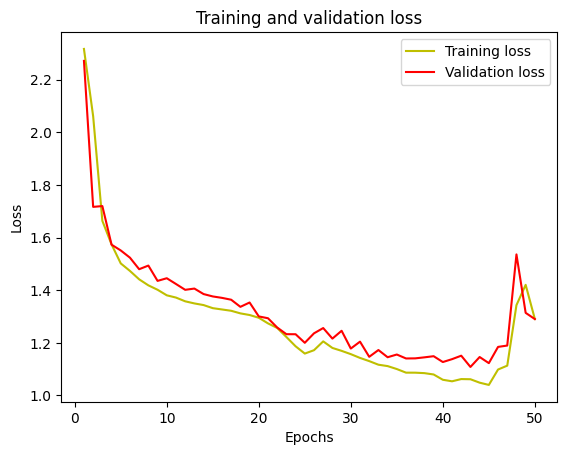

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

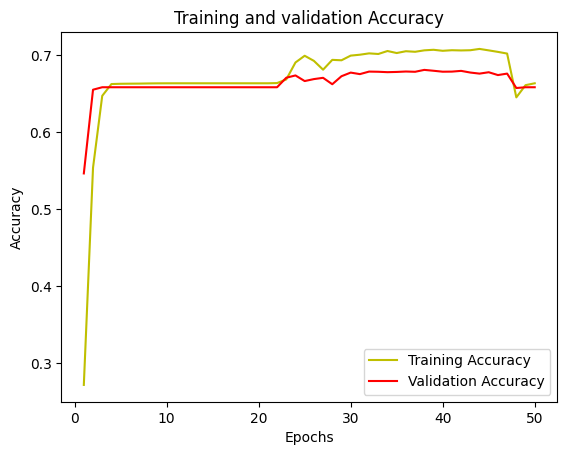

In [ ]:
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#model = get_model()
model.load_weights('test.hdf5')
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')

In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
from keras.metrics import MeanIoU
n_classes = 11
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.059812233


In [ ]:
from sklearn.metrics import confusion_matrix
def compute_iou(y_true, y_pred, num_classes):
    """
    Compute Intersection over Union (IoU) for each class.

    Args:
    - y_true: Ground truth labels, shape (num_samples, height, width)
    - y_pred: Predicted labels, shape (num_samples, height, width)
    - num_classes: Number of classes

    Returns:
    - IoU: IoU for each class
    """
    # Flatten the arrays
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Initialize confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))

    # Calculate IoU for each class
    iou = np.diag(cm) / (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))

    return iou


In [ ]:
# Assuming you have the model and data
# Make predictions on validation/test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)  # Convert probabilities to class labels

# Assuming y_test is in the same format
iou_scores = compute_iou(y_test, y_pred_classes, n_classes)

# Print IoU for each class
for i, iou in enumerate(iou_scores):
    print(f"Class {i} IoU: {iou:.11f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
Class 0 IoU: 0.65793457031
Class 1 IoU: 0.00000000000
Class 2 IoU: 0.00000000000
Class 3 IoU: 0.00000000000
Class 4 IoU: 0.00000000000
Class 5 IoU: 0.00000000000
Class 6 IoU: 0.00000000000
Class 7 IoU: 0.00000000000
Class 8 IoU: 0.00000000000
Class 9 IoU: 0.00000000000
Class 10 IoU: 0.00000000000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


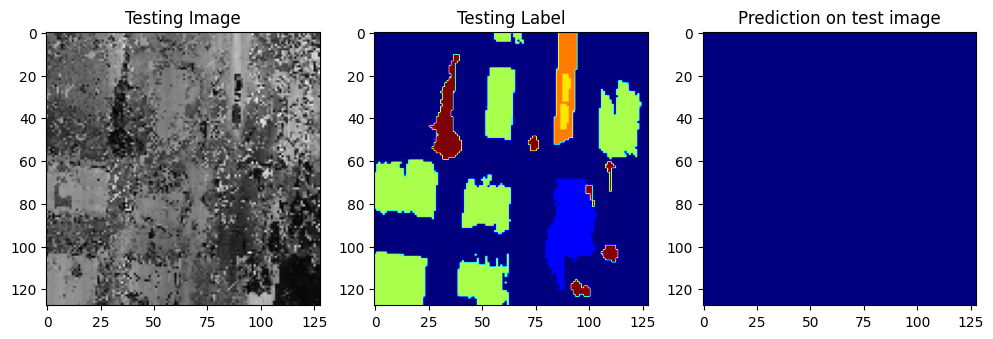

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()
